## Финальное соревнование

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

В данном задании вас ждет неизвестная зависимость. Ваша основная задача: **построить две лучших модели**, минимизирующих среднеквадратичную ошибку (MSE):
1. На первую модель не налагается ограничений.
2. Вторая модель должна быть **линейной**, т.е. представлять собой линейную комбинацию признаков плюс свободный член: $\boldsymbol{w}^{\top}\boldsymbol{x} + b$. При этом __вы можете использовать базовые математические операции для преобразования признаков__: np.exp, np.log, np.pow (полный список доступен в [документации](https://numpy.org/doc/stable/reference/routines.math.html)), а также линейные операции над ними (сумма, умножение на число и пр.). Для преобразования признаков вам будет необходимо написать функцию `my_transformation`. __Кол-во параметров (весов) используемых второй моделью не должно превышать 15 (включая свободный член).__

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в будущем писать код более уверенно

In [226]:
import os
import json

import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import lfilter
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [227]:
assert os.path.exists('hw_final_open_data.npy'), 'Please, download `hw_final_open_data.npy` and place it in the working directory'
assert os.path.exists('hw_final_open_target.npy'), 'Please, download `hw_final_open_target.npy` and place it in the working directory'
data = np.load('hw_final_open_data.npy', allow_pickle=False)
target = np.load('hw_final_open_target.npy', allow_pickle=False)

Разбивка на `train` и `val` опциональна и сделана для вашего удобства.

In [228]:
train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3, random_state=42)

In [4]:
# 0.125*(train_x[:, 0] + train_x[:, 4]+4.25)**2
# 0.25*(train_x[:, 0] + 2.1)**2
# np.log(train_x[:, 1]+10)
# train_x[:, 2] - не нужен (np.delete(train_x, np.where(train_x[:, 2] < 0.), 0))
# train_x[:, 3]+1.7
# np.exp(train_x[:, 4]/2.2)
# train_x[:, 5] + 1.5
# train_x[:, 6] линейно от train_x[:, 2] - не нужен



In [26]:
def transform(X):
    new_X = np.zeros((X.shape[0], 7))
    new_X[:, 0] = (np.exp((X[:, 0]+0.562)*340)/2-0.5)*2
    new_X[:, 1] = (np.log((X[:, 1]+1.75)/2.25 + 0.7)-0.5)*4
    new_X[:, 2] = (np.exp((X[:, 4] + 0.485)*25)-0.75)*2
    new_X[:, 3] = (X[:, 5] - 1.7)/3
    new_X[:, 4] = ((X[:, 4]+0.55)**2 * 100-0.25)*4
    new_X[:, 5] = (((X[:, 0] + X[:, 4]+1.112))**2 * 100-0.25)*4
    return new_X

In [27]:
new_X = transform(train_x)

In [7]:
for i in range(6):
    print(i, np.min(new_X[:, i]), np.max(new_X[:, i]))

0 -0.8434554932884833 1.0246754227352985
1 -1.0999937449655417 0.8344456833452227
2 -0.9519993279262248 0.9440946586927477
3 -0.6892896033015411 0.7139476548516696
4 -0.9301459101212174 1.1328326308430872
5 -0.9759079895016887 1.2557539046619346


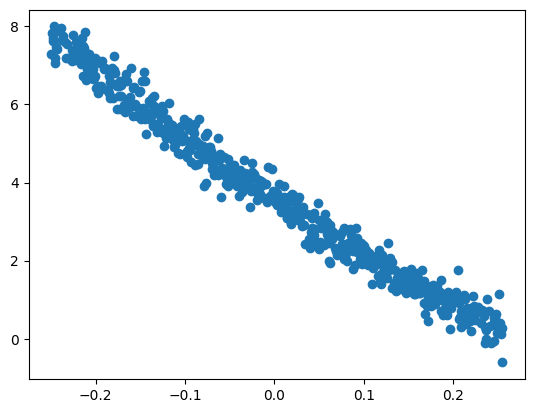

In [128]:
plt.scatter(train_x[:, 0]*train_x[:, 3], train_y)

In [28]:
# l = Lasso(alpha=0.01, max_iter=70)
l = Ridge(alpha=0.2)
l.fit(new_X, train_y)

Ridge(alpha=0.2)

In [29]:
new_val = transform(valid_x)

In [30]:
print(
    f'train mse =\t {mean_squared_error(np.round(l.predict(new_X), 2), np.round(train_y)):.5f}',
    f'validation mse = {mean_squared_error(np.round(l.predict(new_val), 2), np.round(valid_y)):.5f}',
    sep='\n'
)

train mse =	 0.18903
validation mse = 0.16760


### Модель №1
Напоминаем, в первой части задания ваша основная задача – получить наилучший результат без ограничений на модель. Сдаваться будут только предсказания модели.

In [11]:
class New:
    def __init__(self, xgb_eta=0.01, xgb_max_depth=1, lasso_alpha=0.01, rf_n_est=65, rf_max_depth=2, rf_max_features=3, ridge_alpha=0.01):
        self.xgb = XGBRegressor(eta=xgb_eta, max_depth=xgb_max_depth)
        self.lasso = Lasso(alpha=lasso_alpha, random_state=42)
        self.rf = RandomForestRegressor(n_estimators=rf_n_est, max_depth=rf_max_depth, max_features=rf_max_features, random_state=42)
        self.final = Ridge(alpha=ridge_alpha, random_state=42)

    def fit(self, X_, y):
        X = X_
        self.xgb.fit(X[:, 0].reshape((-1, 1)), y)
        self.lasso.fit(X, y)
        self.rf.fit(X[:, [0, 1, 3, 4, 5]], y)
        self.final.fit(np.array([self.xgb.predict(X[:, 0].reshape((-1, 1))), self.rf.predict(X[:, [0, 1, 3, 4, 5]]), self.lasso.predict(X)]).T, y)
    
    def predict(self, X_):
        X = X_
        return self.final.predict(np.array([self.xgb.predict(X[:, 0].reshape((-1, 1))), self.rf.predict(X[:, [0, 1, 3, 4, 5]]), self.lasso.predict(X)]).T)



In [12]:
regr = New()
regr.fit(new_X, train_y)

print(
    f'train mse =\t {mean_squared_error(np.round(regr.predict(new_X), 2), np.round(train_y)):.5f}',
    f'validation mse = {mean_squared_error(np.round(regr.predict(new_val), 2), np.round(valid_y)):.5f}',
    sep='\n'
)



train mse =	 0.19373
validation mse = 0.17659


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.295e-01, tolerance: 2.667e-01
  model = cd_fast.enet_coordinate_descent(


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


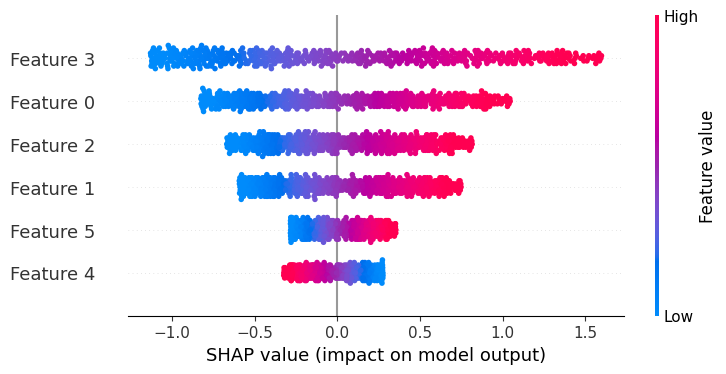

In [13]:
import shap
masker = shap.maskers.Independent(new_X)
explainer = shap.explainers.Linear(l, masker) # YOUR CODE HERE
shap_values = explainer(new_X)
shap.plots.beeswarm(shap_values)

##### Сдача первой части соревнования
Загрузите файл `hw_final_closed_data.npy` (ссылка есть на странице с заданием). Если вы используете sklearn-совместимую модель, для генерации посылки вы можете воспользоваться функцией `get_predictions`. В ином случае перепишите функцию для вашей модели и запустите код под следующей ячейкой для генерации посылки.

In [14]:
assert os.path.exists('hw_final_closed_data.npy'), 'Please, download `hw_final_closed_data.npy` and place it in the working directory'
closed_data = np.load('hw_final_closed_data.npy', allow_pickle=False)

Если необходимо, преобразуйте данные. Преобразованную матрицу объект-признак сохраните в переменную `closed_data`.

In [15]:
# optional transformations
closed_data = transform(closed_data)

In [16]:
def get_predictions(model, eval_data, step=10):
    predicted_values = model.predict(eval_data)
    return predicted_values

Обращаем ваше внимание, предсказания округляются до сотых!

In [17]:
predicted_values = get_predictions(model=l, eval_data=closed_data) - np.random.normal(0, 0.025, closed_data.shape[0])

assert predicted_values.shape == (closed_data.shape[0], ) # predictions should be just one-dimensional array



In [18]:
# do not change the code in the block below
# __________start of block__________
def float_list_to_comma_separated_str(_list):
    _list = list(np.round(np.array(_list), 2))
    return ','.join([str(x) for x in _list])

submission_dict = {
    'predictions': float_list_to_comma_separated_str(predicted_values)
}
with open('submission_dict_final_p01.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
    
print('File saved to `submission_dict_final_p01.json`')
# __________end of block__________

File saved to `submission_dict_final_p01.json`


### Модель №2
Функция `my_transformation` принимает на вход матрицу объект-признак (`numpy.ndarray` типа `np.float`) и преобразует ее в новую матрицу. Данная функция может использовать только numpy-операции, а также арифметические действия.

Для примера доступна функция ниже. Она лишь добавляет новый признак, представляющий собой произведение первого и второго исходных признаков (считая с нуля).

In [229]:
def my_transformation(X):
    new_X = np.zeros((X.shape[0], 7))
    # new_X[:, 0] = (np.exp((X[:, 0]+0.562)*340)/2-0.5)*2
    # new_X[:, 1] = (np.log((X[:, 1]+1.75)/2.25 + 0.7)-0.5)*4
    new_X[:, 2] = (np.exp((X[:, 4] + 0.485)*25)-0.75)*2
    new_X[:, 3] = (X[:, 5] - 1.7)/3
    # new_X[:, 4] = ((X[:, 4]+0.55)**2 * 100-0.25)*4
    new_X[:, 5] = (((X[:, 0] + X[:, 4]+1.112))**2 * 100-0.25)*4
    new_X[:, 6] = X[:, 0] * X[:, 3]
    

    return new_X

In [230]:
transformed_train_x = my_transformation(train_x) # 8773 первые 0-5

In [231]:
lr = Ridge(alpha=0.126, max_iter=10, solver='cholesky')
lr.fit(transformed_train_x, train_y)

print(
    f'train mse =\t {mean_squared_error(lr.predict(transformed_train_x), train_y):.5f}',
    f'validation mse = {mean_squared_error(lr.predict(my_transformation(valid_x)), valid_y):.5f}',
    sep='\n'
)

train mse =	 0.09116
validation mse = 0.08767


Обращаем ваше внимание, что параметры линейной модели будут округляться до __четырех знаков после запятой__. Это не должно сильно повлиять на качество предсказаний:

In [193]:
original_predictions = lr.predict(transformed_train_x)
rounded_predictions = transformed_train_x.dot(np.round(lr.coef_, 4)) + np.round(lr.intercept_, 4)


assert np.allclose(original_predictions, rounded_predictions, atol=1e-3)

Параметры вашей модели:

In [194]:
w_list = list(np.round(lr.coef_, 4))
print(f'w_submission = {list(np.round(lr.coef_, 4))}\nb_submission = {np.round(lr.intercept_, 4)}')

w_submission = [0.0, 0.0, 1.1657, 2.7311, 0.0, 0.6945, 0.2142]
b_submission = 3.844


Напоминаем, ваша модель не должна использовать более 15 параметров (14 весов плюс свободный член).

In [42]:
assert len(w_list) + 1 <= 15

##### Сдача второй части соревнования
Для сдачи вам достаточно отправить функцию `my_transformation` и параметры вашей модели в контест в задачу №2. Пример посылки доступен ниже. Имортирование `numpy` также необходимо.

In [25]:
# __________example_submission_start__________
import numpy as np
def my_transformation(X: np.ndarray):
    new_X = np.zeros((X.shape[0], 6))
    new_X[:, 0] = (X[:, 0] + 1.7)**2
    new_X[:, 1] = np.log(X[:, 1]+10)
    new_X[:, 2] = X[:, 3]+1.7
    new_X[:, 3] = np.exp(X[:, 4]/2.2)
    new_X[:, 4] = X[:, 5] + 1.5
    new_X[:, 5] = (X[:, 4]+2.55)**2
    return new_X

w_submission = [-0.0851, 0.0197, -0.2865, 0.1759, 0.5424, 0.4345]
b_submission = 0.1934
# __________example_submission_end__________

На этом задание завершено. Поздравляем!